yolo task=detect mode=train model=yolov8n.pt data=data.yaml epochs=64 imgsz=228

## OCR Confi && yolo

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import easyocr
from typing import Dict, Any

# Load YOLO OBB model and EasyOCR reader
model = YOLO("Models/res_temp_box.pt")  # Replace with your trained OBB model path
reader = easyocr.Reader(['en'])

def detect_and_recognize(image_path: str) -> Dict[str, Dict[str, Any]]:
    results = model(image_path, conf=0.15)
    output = {}
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for result in results:
        if result.obb is not None:  # Check if OBB detections exist
            obb_boxes = result.obb.xyxyxyxy.cpu().numpy()  # Extract OBB coordinates
            class_ids = result.obb.cls.cpu().numpy()  # Extract class IDs
            confidences = result.obb.conf.cpu().numpy()  # Extract confidence scores

            for i, box in enumerate(obb_boxes):
                class_id = int(class_ids[i])
                confidence = confidences[i]
                class_name = result.names[class_id]

                # Draw the OBB on the image
                pts = box.reshape(4, 2).astype(np.int32)
                cv2.polylines(image_rgb, [pts], isClosed=True, color=(0, 0, 255), thickness=2)
                cv2.putText(image_rgb, f"{class_name} {confidence:.2f}",
                            (pts[0][0], pts[0][1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

                # Crop the region inside the OBB
                x_min, y_min = np.min(pts, axis=0)
                x_max, y_max = np.max(pts, axis=0)
                cropped = image[y_min:y_max, x_min:x_max]

                # Apply OCR on the cropped region
                if cropped.size > 0:
                    ocr_results = reader.readtext(cropped)
                    for detection in ocr_results:
                        ocr_text = detection[1]
                        ocr_confidence = detection[2]
                        ocr_confidence = round(detection[2], 2) 
                        print(f"OCR Text: {ocr_text}, Confidence: {ocr_confidence}")

        else:
            print("No OBB detections found in the image.")

    # Display the image with OBBs
    cv2.imshow("Detections", image_rgb)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return output

# Test the function
detect_and_recognize('test_images/cd_cr/k_27.jpg')

## Model+easyocr

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import easyocr
import matplotlib.pyplot as plt

# Load YOLOv8 model and EasyOCR reader
model = YOLO("Models/model_1_0_2.pt")
reader = easyocr.Reader(['en'])

from typing import Dict, Any

def detect_and_recognize(image_path: str) -> Dict[str, Dict[str, Any]]:
    results = model.predict(source=image_path, conf=0.15, save=False)
    output = {}

    # Load the image to draw bounding boxes
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying with Matplotlib

    for result in results:
        for box in result.boxes:
            # Extract detection info
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0])
            class_id = int(box.cls)
            class_name = result.names[class_id]
            yolo_conf = box.conf.item()  # YOLO confidence

            # Process image region for OCR
            cropped = image[y_min:y_max, x_min:x_max]
            ocr_results = reader.readtext(cropped)
            
            # Draw bounding box on the image
            cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
            cv2.putText(image_rgb, f"{class_name} {yolo_conf:.2f}",
                        (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            # Print YOLO class and confidence
            print(f"YOLO Class: {class_name}, YOLO Confidence: {yolo_conf:.2f}")

            # Process OCR results for each bounding box
            for detection in ocr_results:
                ocr_text = detection[1]
                ocr_confidence = detection[2]
                # Print OCR text and confidence
                print(f"OCR Text: {ocr_text}, OCR Confidence: {ocr_confidence:.2f}")

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()

    return output

# Test the function
detect_and_recognize('testimg/images/1.png')


## Custom OCR Model 

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  
model.train(data='data.yaml', epochs=50, imgsz=640)


In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load your trained YOLOv8 model
model = YOLO("Models/ocr-best.pt")

def detect_and_sort_digits(image_path, show_bboxes=True, gap_multiplier=1.5):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image)

    # Extract bounding boxes
    bboxes = []
    boxes = results[0].boxes
    for box, conf, cls in zip(boxes.xyxy, boxes.conf, boxes.cls):
        x_min = int(box[0].item())
        y_min = int(box[1].item())
        x_max = int(box[2].item())
        y_max = int(box[3].item())
        confidence = float(conf.item())
        class_id = int(cls.item())
        if class_id != 10:  # Assuming class 10 is dot ('.')
            bboxes.append([x_min, y_min, x_max, y_max, confidence, class_id])

    # Print the class labels (IDs) and bounding boxes
    print("Detected Bboxes with Class IDs and Confidence:")
    for bbox in bboxes:
        print(f"Class ID: {bbox[5]}, Bbox: {bbox[:4]}, Confidence: {bbox[4]:.2f}")
    
    if show_bboxes:
        for bbox in bboxes:
            x_min, y_min, x_max, y_max, conf, label = bbox
            cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image_rgb, 
                        f"{label} ({conf:.2f})",
                        (x_min, y_min - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.7, 
                        (0, 255, 0), 
                        2)

        plt.figure(figsize=(10, 6))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

    digit_sequence = sort_and_extract_digits(bboxes, gap_multiplier)
    
    return digit_sequence

def sort_and_extract_digits(bboxes, gap_multiplier=1.5):
    if not bboxes:
        return ""
    
    # Sort by horizontal position
    sorted_bboxes = sorted(bboxes, key=lambda b: (b[0] + b[2])/2)
    avg_width = sum(b[2]-b[0] for b in sorted_bboxes)/len(sorted_bboxes)
    gap_threshold = avg_width * gap_multiplier
    
    # Group digits based on x-axis gaps
    groups = []
    current_group = [sorted_bboxes[0]]
    
    for bbox in sorted_bboxes[1:]:
        last_bbox = current_group[-1]
        gap = bbox[0] - last_bbox[2] 
        
        if gap > gap_threshold:
            groups.append(current_group)
            current_group = [bbox]
        else:
            current_group.append(bbox)
    
    groups.append(current_group)  
    return " ".join(["".join(str(b[5]) for b in group) for group in groups])

# Test with an example
image_path = 'testimg/ok/7.jpg'
result = detect_and_sort_digits(image_path, gap_multiplier=1.5)
print(f"Formatted Number: {result}")


## double detection + res_temp

In [ ]:
import sys
import numpy as np
from ultralytics import YOLO
from PIL import Image

def crop_regions(image, obb):
    """Crops regions based on OBB detection and returns (cropped image, x-coordinate)."""
    cropped_regions = []

    if obb is not None:
        boxes = obb.xyxyxyxy.cpu().numpy()
        for box in boxes:
            pts = box.reshape(4, 2).astype(int)
            x_min, y_min = np.min(pts, axis=0)
            x_max, y_max = np.max(pts, axis=0)

            cropped = image.crop((x_min, y_min, x_max, y_max))
            cropped_regions.append((cropped, x_min))  # Store x_min for sorting
    
    return cropped_regions

def detect_and_crop(analog_box, image):
    """Runs first detection model (OBB-based) and returns cropped regions."""
    results = analog_box(image)
    cropped_regions = []
    
    for r in results:
        cropped_regions = crop_regions(image, r.obb)

    return cropped_regions

def detect_final_classes(model_4, cropped_regions):
    """Runs second detection model (OBB-based OCR) and returns sorted detected classes."""
    detected_data = []

    for cropped, x_min in cropped_regions:
        results = model_4(cropped)
        
        for r in results:
            if r.obb is not None:
                for i, class_id in enumerate(r.obb.cls.cpu().numpy()):
                    class_name = r.names[int(class_id)]
                    box_pts = r.obb.xyxyxyxy.cpu().numpy()[i].reshape(4, 2)
                    x_center = np.mean(box_pts[:, 0])

                    detected_data.append((class_name, x_center))

    # Sort detected characters by x-center (left to right)
    detected_data.sort(key=lambda x: x[1])
    
    # Extract only class names in order
    final_classes = [item[0] for item in detected_data]

    # Process to place '.' after second digit
    if "dot" in final_classes:
        final_classes = [c if c != "dot" else "." for c in final_classes]
        if len(final_classes) > 2 and "." in final_classes:
            final_classes.remove(".")
            final_classes.insert(2, ".")
            
        # Convert class names into final formatted output
        final_classes = [
            "." if cls == "dot" else "°" if cls == "degree" else cls  
            for cls, _ in detected_data
        ]
            
    return final_classes

def main(analog_box, model_path_4, image_path):
    """Main function to run both detections using OBB models and return results."""
    analog_box = YOLO(analog_box)
    model_4 = YOLO(model_path_4)

    image = Image.open(image_path).convert("RGB")
    cropped_regions = detect_and_crop(analog_box, image)
    final_classes = detect_final_classes(model_4, cropped_regions)
    
    return "".join(final_classes)

if __name__ == "__main__":
    analog_box = "Models/res_temp_box.pt"
    model_path_4 = "Models/temp_ocr.pt"
    image_path = "test_images/cd_cr/k_2.jpg"
    result = main(analog_box, model_path_4, image_path)
    print(f"Detected Value: {result}")

## renaming

In [ ]:
import os

def rename_images(folder_path):
    # Get a list of image files in the folder (sorted to maintain order)
    image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif")
    images = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)])

    if not images:
        print("No images found in the folder.")
        return

    # Rename each image
    for index, image in enumerate(images, start=1):
        ext = os.path.splitext(image)[1]  # Get file extension
        new_name = f"{index}{ext}"
        old_path = os.path.join(folder_path, image)
        new_path = os.path.join(folder_path, new_name)

        os.rename(old_path, new_path)
        print(f"Renamed: {image} -> {new_name}")

if __name__ == "__main__":
    folder_path = "cr test 29 may"  
    rename_images(folder_path)

Renamed: VID20250529121420_frame_0000.jpg -> 1.jpg
Renamed: VID20250529121420_frame_0001.jpg -> 2.jpg
Renamed: VID20250529121420_frame_0002.jpg -> 3.jpg
Renamed: VID20250529121442_frame_0000.jpg -> 4.jpg
Renamed: VID20250529121442_frame_0001.jpg -> 5.jpg
Renamed: VID20250529121442_frame_0002.jpg -> 6.jpg
Renamed: VID20250529121442_frame_0003.jpg -> 7.jpg
Renamed: VID20250529121442_frame_0004.jpg -> 8.jpg
Renamed: VID20250529121442_frame_0005.jpg -> 9.jpg
Renamed: VID20250529121442_frame_0006.jpg -> 10.jpg
Renamed: VID20250529121442_frame_0007.jpg -> 11.jpg
Renamed: VID20250529121442_frame_0008.jpg -> 12.jpg
Renamed: VID20250529121442_frame_0009.jpg -> 13.jpg
Renamed: VID20250529121442_frame_0010.jpg -> 14.jpg
Renamed: VID20250529121442_frame_0011.jpg -> 15.jpg
Renamed: VID20250529121442_frame_0012.jpg -> 16.jpg
Renamed: VID20250529121442_frame_0013.jpg -> 17.jpg
Renamed: VID20250529121442_frame_0014.jpg -> 18.jpg
Renamed: VID20250529121442_frame_0015.jpg -> 19.jpg
Renamed: VID202505291

## Detection

In [12]:
import sys
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

def get_crops_and_boxes(image, obbs):
    """
    From a list of obb predictions, return:
      - crops: list of axis-aligned image crops
      - coords: list of (x, y, w, h) tuples for each crop
    """
    crops = []
    coords = []
    for obb in obbs:
        # obb: tensor of shape (N, 8) where each row is [x1,y1, x2,y2, x3,y3, x4,y4]
        pts = obb.cpu().numpy().reshape(-1, 2).astype(np.int32)
        # compute an axis-aligned bounding rect around the 4 points
        x, y, w, h = cv2.boundingRect(pts)
        crop = image[y : y + h, x : x + w]
        crops.append(crop)
        coords.append((x, y, w, h))
    return crops, coords

def visualize_with_matplotlib(orig_bgr, crops, coords, class_names):
    # convert original to RGB
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
    # draw boxes on the RGB image for display
    for (x, y, w, h), cname in zip(coords, class_names):
        cv2.rectangle(orig_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(orig_rgb, cname, (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # set up subplots: one for the full image, then one per crop
    n_crops = len(crops)
    fig, axes = plt.subplots(1, n_crops + 1, figsize=(4 * (n_crops + 1), 4))
    axes[0].imshow(orig_rgb)
    axes[0].set_title("Full image with OBBs")
    axes[0].axis("off")

    for i, (crop_bgr, (x, y, w, h), cname) in enumerate(zip(crops, coords, class_names), start=1):
        crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
        axes[i].imshow(crop_rgb)
        axes[i].set_title(f"{cname}\n(x={x}, y={y}, w={w}, h={h})")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

def main(analog_box, image_path):
    # Load model
    model = YOLO(analog_box)

    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read image at", image_path)
        sys.exit(1)

    # Run inference
    results = model(image)

    # Gather all OBBs and class names
    all_obbs = []
    all_names = []
    for r in results:
        if r.obb is not None:
            all_obbs.extend(r.obb.xyxyxyxy)      # tensor of shape (N,8)
            for cls_id in r.obb.cls.cpu().numpy():
                all_names.append(r.names[int(cls_id)])

    if not all_obbs:
        print("No oriented boxes detected.")
        return

    # Extract crops and their coords
    crops, coords = get_crops_and_boxes(image, all_obbs)

    # Visualize using matplotlib
    visualize_with_matplotlib(image, crops, coords, all_names)

if __name__ == "__main__":
    analog_box = "Models/res_detect.pt"
    image_path = "new_data/7.jpg"
    main(analog_box, image_path)



0: 288x640 4 digits, 65.5ms
Speed: 8.0ms preprocess, 65.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)
No oriented boxes detected.


# FRAMES EXTRACTION

In [2]:
import cv2
import os

def extract_frames(video_path, output_folder, frame_interval_ms=100):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int((frame_interval_ms / 1000) * frame_rate)
    
    frame_count = 0
    saved_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Stop if end of video
        
        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{saved_count:04d}.png")
            cv2.imwrite(frame_filename, frame, [cv2.IMWRITE_PNG_COMPRESSION, 0])
            saved_count += 1
        
        frame_count += 1
    
    cap.release()
    print(f"Extracted {saved_count} frames and saved in {output_folder}")

# Example usage
video_path = "v1.mp4"  # Change this to your video file
output_folder = "test"
extract_frames(video_path, output_folder)


Extracted 697 frames and saved in test


## CROPPING

In [ ]:
import sys
import cv2
import numpy as np
import easyocr
import os
from ultralytics import YOLO

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

def save_cropped_images(image, obb, output_folder, image_name):
    boxes = obb.xyxyxyxy.cpu().numpy()
    
    for i, box in enumerate(boxes):
        pts = box.reshape(4, 2).astype(np.int32)
        
        # Crop the detected region
        x_min, y_min = np.min(pts, axis=0)
        x_max, y_max = np.max(pts, axis=0)
        cropped_region = image[y_min:y_max, x_min:x_max]
        
        # Save cropped region
        if cropped_region.size > 0:
            crop_filename = os.path.join(output_folder, f"{image_name}_crop_{i}.png")
            cv2.imwrite(crop_filename, cropped_region)

def process_dataset(analog_box, dataset_folder, output_folder):
    # Load the YOLO OBB model for detection
    analog_box = YOLO(analog_box)
    
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Iterate over images in the dataset folder
    for image_name in os.listdir(dataset_folder):
        image_path = os.path.join(dataset_folder, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not read image {image_name}")
            continue
        
        # Run inference using analog_box for detection
        results = analog_box(image)
        
        for r in results:
            if r.obb is not None:
                save_cropped_images(image, r.obb, output_folder, image_name)
    
    print("Processing complete. Cropped images saved in", output_folder)

if __name__ == "__main__":
    analog_box = "Models/temp_ocr.pt"
    dataset_folder = "new_images"  # Change to your dataset folder
    output_folder = "new_data"  # Folder to save cropped images
    process_dataset(analog_box, dataset_folder, output_folder)

## remaining test

In [ ]:
import sys
import cv2
import numpy as np
import easyocr
from ultralytics import YOLO

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

def draw_obb(image, obb):
    boxes = obb.xyxyxyxy.cpu().numpy()
    extracted_texts = []

    for i, box in enumerate(boxes):
        pts = box.reshape(4, 2).astype(np.int32)
        
        # Draw the bounding box
        cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
        
        # Crop the detected region
        x_min, y_min = np.min(pts, axis=0)
        x_max, y_max = np.max(pts, axis=0)
        cropped_region = image[y_min:y_max, x_min:x_max]
        
        # Apply OCR on the cropped region
        if cropped_region.size > 0:
            text_results = reader.readtext(cropped_region)
            detected_text = " ".join([text[1] for text in text_results])
            extracted_texts.append(detected_text)

            # Put extracted text on the image
            cv2.putText(image, detected_text, (x_min, y_min - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    return image, extracted_texts

def main(model_path_3, image_path):
    # Load the YOLO OBB model for detection
    model_3 = YOLO(model_path_3)
    
    # Read the input image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read image at", image_path)
        sys.exit(1)
    
    # Run inference using model_3 for detection
    results = model_3(image)
    
    all_extracted_texts = []
    
    # Iterate over the results and draw OBB predictions
    for r in results:
        if r.obb is not None:
            image, extracted_texts = draw_obb(image, r.obb)
            all_extracted_texts.extend(extracted_texts)
            for i, class_id in enumerate(r.obb.cls.cpu().numpy()):
                class_name = r.names[int(class_id)]
                print(f"Detected class ID: {class_id}, Class name: {class_name}")
            
            # Print extracted texts from OCR
            for idx, text in enumerate(extracted_texts):
                print(f"OCR Extracted Text {idx + 1}: {text}")
    
    return image, all_extracted_texts


if __name__ == "__main__":
    model_path_3 = "Models/Remaining_tests_model.pt"
    image_path = "test_images/hv_pd/i_319.png"
    main(model_path_3, image_path)


## n2n temp_ocr

In [ ]:
import sys
import numpy as np
from ultralytics import YOLO
from PIL import Image
import easyocr

def crop_regions(image, obb):
    """Crops regions based on OBB detection and returns (cropped, class_id, x_min)."""
    regions = []
    if obb is not None:
        boxes = obb.xyxyxyxy.cpu().numpy()
        classes = obb.cls.cpu().numpy()
        confs = obb.conf.cpu().numpy()
        for box, cls, conf in zip(boxes, classes, confs):
            if conf < 0.6:
                continue
            pts = box.reshape(4, 2).astype(int)
            x_min, y_min = np.min(pts, axis=0)
            x_max, y_max = np.max(pts, axis=0)
            cropped = image.crop((x_min, y_min, x_max, y_max))
            regions.append((cropped, int(cls), x_min))
    return regions


def detect_and_process(analog_box_model, ocr_model, reader, image):
    """Detects temp or res regions, applies OCR logic, and returns list of (class_name, value)."""
    results = analog_box_model(image)
    output_values = []

    for r in results:
        regions = crop_regions(image, r.obb)
        regions.sort(key=lambda x: x[2])  # sort by x_min

        for cropped, cls_id, _ in regions:
            cls_name = r.names[cls_id]
            if cls_name == 'temp':
                # YOLO OCR logic
                yolo_out = ocr_model(cropped)
                chars = []
                for out in yolo_out:
                    if out.obb is not None:
                        confs = out.obb.conf.cpu().numpy()
                        for i, c in enumerate(out.obb.cls.cpu().numpy()):
                            if confs[i] < 0.6:
                                continue
                            name = out.names[int(c)]
                            pts = out.obb.xyxyxyxy.cpu().numpy()[i].reshape(4,2)
                            x_ctr = np.mean(pts[:,0])
                            chars.append((name, x_ctr))
                chars.sort(key=lambda x: x[1])
                seq = ['.' if n=='dot' else '°' if n=='degree' else n for n,_ in chars]
                value = ''.join(seq)
            else:
                # EasyOCR for residual class
                text = reader.readtext(np.array(cropped), detail=0)
                value = text[0] if text else ''

            output_values.append((cls_name, value))

    return output_values


def main(box_model_path, ocr_model_path, image_path):
    # load models
    analog_box = YOLO(box_model_path)
    yolo_ocr = YOLO(ocr_model_path)
    reader = easyocr.Reader(['en'], gpu=False)

    image = Image.open(image_path).convert('RGB')
    results = detect_and_process(analog_box, yolo_ocr, reader, image)

    # print results
    for cls, val in results:
        print(f"{cls.capitalize()} Detected: {val}")

if __name__ == '__main__':
    box_model = 'Models/res_temp_box.pt'
    ocr_model = 'Models/temp_ocr.pt'
    img_path = 'test_images/f3.png'
    main(box_model, ocr_model, img_path)


## Synthetic digit

In [ ]:
import os
import math
import random
import numpy as np
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance
import cv2

# ----------------- CONFIGURATION -----------------
OUTPUT_DIR = 'synthetic_digits'
IMAGE_SIZE = (64, 128)  # width, height
BG_COLOR = (0, 0, 0)
SEGMENT_ON_COLOR = (255, 50, 50)
SEGMENT_OFF_COLOR = (50, 0, 0)
SEGMENT_THICKNESS = 10
NUM_SAMPLES_PER_CLASS = 500
AUG_ROTATION = 15  # degrees
NOISE_LEVEL = 0.05  # fraction of pixels
BRIGHTNESS_VARIATION = 0.3  # ± variation
GLOW_RADIUS = 8     # blur radius for glow effect
GLOW_INTENSITY = 0.6 # blending factor for glow

# Segment definitions: each segment is a polygon relative to W,H
SEGMENTS = {
    0: [(0.2, 0.05), (0.8, 0.05), (0.7, 0.15), (0.3, 0.15)],
    1: [(0.8, 0.05), (0.9, 0.2), (0.8, 0.45), (0.7, 0.35)],
    2: [(0.8, 0.55), (0.9, 0.8), (0.8, 0.95), (0.7, 0.85)],
    3: [(0.2, 0.85), (0.8, 0.85), (0.7, 0.95), (0.3, 0.95)],
    4: [(0.1, 0.55), (0.2, 0.8), (0.3, 0.85), (0.2, 0.65)],
    5: [(0.1, 0.2), (0.2, 0.35), (0.3, 0.45), (0.2, 0.2)],
    6: [(0.2, 0.45), (0.8, 0.45), (0.7, 0.55), (0.3, 0.55)],
}
# Digit to segment mapping
DIGIT_PATTERNS = {
    '0': [1,1,1,1,1,1,0],
    '1': [0,1,1,0,0,0,0],
    '2': [1,1,0,1,1,0,1],
    '3': [1,1,1,1,0,0,1],
    '4': [0,1,1,0,0,1,1],
    '5': [1,0,1,1,0,1,1],
    '6': [1,0,1,1,1,1,1],
    '7': [1,1,1,0,0,0,0],
    '8': [1,1,1,1,1,1,1],
    '9': [1,1,1,1,0,1,1],
    '.': []  # handled separately
}

# --------------------------------------------------

def draw_digit(digit, size):
    w, h = size
    img = Image.new('RGB', size, BG_COLOR)
    draw = ImageDraw.Draw(img)

    # draw segments
    pattern = DIGIT_PATTERNS.get(digit, [])
    for idx, polygon in SEGMENTS.items():
        pts = [(x * w, y * h) for x, y in polygon]
        color = SEGMENT_ON_COLOR if idx < len(pattern) and pattern[idx] else SEGMENT_OFF_COLOR
        draw.polygon(pts, fill=color)

    # dot
    if digit == '.':
        radius = SEGMENT_THICKNESS
        cx, cy = int(w * 0.9), int(h * 0.9)
        draw.ellipse((cx - radius, cy - radius, cx + radius, cy + radius), fill=SEGMENT_ON_COLOR)

    return img


def augment(img):
    # Create glow by blurring bright areas
    glow_layer = img.filter(ImageFilter.GaussianBlur(radius=GLOW_RADIUS))
    img = Image.blend(img, glow_layer, GLOW_INTENSITY)

    # Brightness jitter
    enhancer = ImageEnhance.Brightness(img)
    factor = 1 + BRIGHTNESS_VARIATION * (random.random() * 2 - 1)
    img = enhancer.enhance(factor)

    # Convert to array for cv2 operations
    arr = np.array(img)

    # Add Gaussian noise
    noise = np.random.randn(*arr.shape) * 255 * NOISE_LEVEL
    arr = np.clip(arr + noise, 0, 255).astype(np.uint8)

    # Random Gaussian blur for additional glow/softness
    if random.random() < 0.5:
        k = random.choice([3, 5, 7])
        arr = cv2.GaussianBlur(arr, (k, k), 0)

    # Rotation
    angle = random.uniform(-AUG_ROTATION, AUG_ROTATION)
    M = cv2.getRotationMatrix2D((IMAGE_SIZE[0] // 2, IMAGE_SIZE[1] // 2), angle, 1)
    arr = cv2.warpAffine(arr, M, IMAGE_SIZE, borderMode=cv2.BORDER_REPLICATE)

    return Image.fromarray(arr)


def main():
    # Create output directories
    for cls in DIGIT_PATTERNS.keys():
        os.makedirs(os.path.join(OUTPUT_DIR, cls), exist_ok=True)

    # Generate samples
    for cls in DIGIT_PATTERNS.keys():
        for i in range(NUM_SAMPLES_PER_CLASS):
            base_img = draw_digit(cls, IMAGE_SIZE)
            img_aug = augment(base_img)
            filename = f"{cls}_{i:04d}.png"
            img_aug.save(os.path.join(OUTPUT_DIR, cls, filename))

    print("Synthetic dataset with glow/shiny effect generation complete.")

if __name__ == '__main__':
    main()


## CNN

In [40]:
import os
import cv2
import numpy as np
from collections import defaultdict
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf

# ---- CONFIGURATION ----
dataset_path = 'dataset_synthetic'      # top-level folder with class subfolders (0-9, dot)
image_size = (128, 128)
batch_size = 16
epochs = 20
model_output = 'digit_cnn_model_1.2.h5'
random_seed = 42
# ------------------------

# 1. Load and preprocess data
def load_image_data(path, img_size):
    X, y = [], []
    class_names = sorted([d for d in os.listdir(path)
                          if os.path.isdir(os.path.join(path, d))])
    class_map = {name: idx for idx, name in enumerate(class_names)}
    for label in class_names:
        folder = os.path.join(path, label)
        for fn in os.listdir(folder):
            if fn.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img_path = os.path.join(folder, fn)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(class_map[label])
    X = np.expand_dims(np.array(X, dtype='float32') / 255.0, -1)
    y = np.array(y, dtype='int32')
    return X, y, class_map

print('Loading data...')
X, y, class_map = load_image_data(dataset_path, image_size)
num_classes = len(class_map)
print(f'  Samples: {X.shape[0]}, Classes: {num_classes}')

# 2. Split dataset manually to handle small class sizes
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

# Group indices by class
idxs_by_class = defaultdict(list)
for idx, label in enumerate(y):
    idxs_by_class[label].append(idx)

train_idxs, val_idxs, test_idxs = [], [], []
for label, idxs in idxs_by_class.items():
    n = len(idxs)
    np.random.shuffle(idxs)
    if n >= 5:
        n_train = int(0.6 * n)
        n_val = int(0.2 * n)
        train_idxs += idxs[:n_train]
        val_idxs += idxs[n_train:n_train+n_val]
        test_idxs += idxs[n_train+n_val:]
    elif n >= 3:
        # 50% train, 25% val, 25% test
        n_train = n // 2
        train_idxs += idxs[:n_train]
        val_idxs += idxs[n_train:n_train+1]
        test_idxs += idxs[n_train+1:]
    elif n == 2:
        train_idxs.append(idxs[0])
        test_idxs.append(idxs[1])
    else:
        train_idxs.append(idxs[0])

X_train, y_train = X[train_idxs], y[train_idxs]
X_val, y_val = X[val_idxs], y[val_idxs] if val_idxs else (np.array([]), np.array([]))
X_test, y_test = X[test_idxs], y[test_idxs]

print(f'Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}')

# 3. Build CNN model
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_model((image_size[0], image_size[1], 1), num_classes)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# 4. Train with early stopping
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val) if len(X_val)>0 else None,
    callbacks=callbacks_list
)

# 5. Evaluate on test set
if len(X_test) > 0:
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test accuracy: {test_acc:.4f}')
else:
    print('No test set available.')

# 6. Save the model
os.makedirs(os.path.dirname(model_output) or '.', exist_ok=True)
model.save(model_output)
print(f'Model saved to {model_output}')

Loading data...
  Samples: 5480, Classes: 12
Train: 3283, Val: 1090, Test: 1107
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       73856     
                                        

In [ ]:
X, y, class_map = load_image_data(dataset_path, image_size)
print(f"Class map = {class_map}")
print(f"Total samples loaded = {len(X)}")

Class map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'C': 10, 'dot': 11}
Total samples loaded = 5479


## Lenet Resistance

In [1]:
import os
import joblib
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

# --- CONFIG ---
DATASET_DIR = "dataset_synthetic"   
IMG_SIZE    = (28, 28)
BATCH_SIZE  = 32
EPOCHS      = 8
MODEL_OUT   = "lenet_res_v2.h5"
LABELS_OUT  = "lenet_class_map.pkl"

# 1) load dataset from subdirs
ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42
)

# extract class names
class_names = ds.class_names  # e.g. ['0','1',...,'9','C']
print("Classes:", class_names)

# 2) normalize
normalization = layers.Rescaling(1./255)
ds = ds.map(lambda x, y: (normalization(x), y))

# 3) split into train/val
val_batches = tf.data.experimental.cardinality(ds) // 5
ds_val = ds.take(val_batches)
ds_train = ds.skip(val_batches)

# 4) build LeNet-5 model
def build_lenet(input_shape, n_classes):
    model = models.Sequential([
        layers.Conv2D(6, kernel_size=5, activation='relu', padding='same',
                      input_shape=input_shape),
        layers.AveragePooling2D(pool_size=2),
        layers.Conv2D(16, kernel_size=5, activation='relu'),
        layers.AveragePooling2D(pool_size=2),
        layers.Flatten(),
        layers.Dense(120, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

model = build_lenet(IMG_SIZE + (1,), len(class_names))
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# 5) train
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS
)

# 6) save model and class map
model.save(MODEL_OUT)
# save class mapping label→index
le = LabelEncoder().fit(class_names)
joblib.dump((le, class_names), LABELS_OUT)
print(f"✅ Saved model to {MODEL_OUT} and labels to {LABELS_OUT}")

Found 5791 files belonging to 12 classes.
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'C', 'dot']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 400)               0         
        

c:\Users\soura\Downloads\ML-Model\xsen\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## inference

In [34]:
pip list

Package                      Version
---------------------------- -----------
absl-py                      2.2.2
albucore                     0.0.17
albumentations               1.4.18
annotated-types              0.7.0
anyio                        4.5.2
asttokens                    3.0.0
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.5.2
certifi                      2024.12.14
charset-normalizer           3.4.1
click                        8.1.8
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.1.1
cycler                       0.12.1
debugpy                      1.8.13
decorator                    5.2.1
easyocr                      1.7.2
efficientnet_pytorch         0.7.1
eval_type_backport           0.2.2
exceptiongroup               1.2.2
executing                    2.2.0
fastapi                      0.95.2
filelock                     3.16.1
flatbuffers                  25.2.10

In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from tensorflow.keras.models import load_model

# Define class map: label name -> integer index
class_map = {
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
    '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
    'C': 10, 'dot': 11
}

class YoloCNN_OCR:
    def __init__(
        self,
        yolo_model_path: str,
        cnn_model_path: str,
        image_size: tuple = (128, 128),
        conf_threshold: float = 0.25
    ):
        # Load YOLO detector
        self.detector = YOLO(yolo_model_path)
        # Load CNN classifier
        self.cnn = load_model(cnn_model_path)
        # Invert class_map: index -> label name
        self.inv_map = {v: k for k, v in class_map.items()}
        # Parameters
        self.image_size = image_size
        self.conf_threshold = conf_threshold

    def ocr_image(self, image_path: str) -> str:
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Cannot read {image_path}")

        # 1) Detect with YOLO
        res = self.detector.predict(source=img, verbose=False)[0]
        boxes = res.boxes.xyxy.cpu().numpy()
        confs = res.boxes.conf.cpu().numpy()
        # Filter by confidence
        mask = confs >= self.conf_threshold
        boxes = boxes[mask]

        if len(boxes) == 0:
            return ""

        # 2) Sort detections left-to-right
        boxes = boxes[np.argsort(boxes[:, 0])]

        digits = []
        for x1, y1, x2, y2 in boxes:
            # Crop detection
            crop = img[int(y1):int(y2), int(x1):int(x2)]
            # Preprocess for CNN
            gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, self.image_size)
            inp = resized.astype("float32") / 255.0
            inp = inp.reshape(1, self.image_size[0], self.image_size[1], 1)
            # Predict
            probs = self.cnn.predict(inp, verbose=False)
            label_int = np.argmax(probs, axis=1)[0]
            label = self.inv_map[label_int]
            digits.append('.' if label == 'dot' else label)

        return "".join(digits)

# -------------------
# Example usage
# -------------------
if __name__ == "__main__":
    yolo_model_path = "Models/res_detect.pt"
    cnn_model_path = "Models/digit_cnn_model_1.2.h5"
    test_image_path = "new_data/32.jpg"

    ocr = YoloCNN_OCR(
        yolo_model_path=yolo_model_path,
        cnn_model_path=cnn_model_path,
        image_size=(128, 128),
        conf_threshold=0.5
    )
    raw = ocr.ocr_image(test_image_path)
    print(f"Processed OCR: {raw}")


## detection

(-0.5, 169.5, 34.5, -0.5)

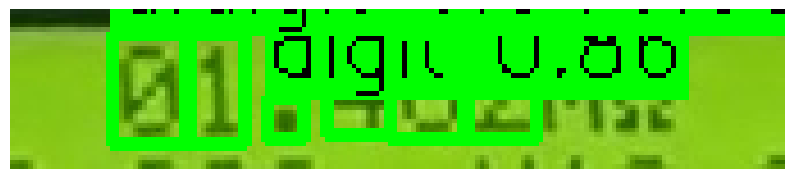

In [6]:
# 1. Install if needed (uncomment if you haven’t already)
# !pip install ultralytics opencv-python matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 2. Configure paths
model_path = "Models/res_detect2.pt"            # your YOLO .pt file
image_path = "1.jpg"  # image to run detection on

# 3. Load model
model = YOLO(model_path)

# 4. Read image
img_bgr = cv2.imread(image_path)
if img_bgr is None:
    raise FileNotFoundError(f"Cannot read {image_path}")

# 5. Run inference
results = model.predict(source=img_bgr, verbose=False)[0]

# 6. Prepare to draw
img = img_bgr.copy()
names = results.names  # dict: class_id → class_name

# 7. Loop over detections
for box, conf, cls in zip(results.boxes.xyxy.cpu().numpy(),
                          results.boxes.conf.cpu().numpy(),
                          results.boxes.cls.cpu().numpy().astype(int)):
    x1, y1, x2, y2 = box.astype(int)
    label = f"{names[cls]} {conf:.2f}"
    # Draw rectangle
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Draw label background
    (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
    cv2.rectangle(img, (x1, y1 - 20), (x1 + w, y1), (0, 255, 0), -1)
    # Put text
    cv2.putText(img, label, (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

# 8. Convert BGR→RGB and display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis("off")


## Lenet

In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import tensorflow as tf

class YoloLeNetOCR:
    def __init__(self,
                 yolo_model_path: str,
                 lenet_model_path: str,
                 image_size=(28, 28),
                 conf_threshold=0.25):
        # YOLO detector
        self.detector = YOLO(yolo_model_path)
        # LeNet CNN
        self.cnn = tf.keras.models.load_model(lenet_model_path)

        # Embedded class names and inverse map (no external pkl needed)
        class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'C', 'dot']
        self.inv_map = {i: label for i, label in enumerate(class_names)}

        # params
        self.image_size = image_size
        self.conf_threshold = conf_threshold

    def preprocess(self, crop: np.ndarray) -> np.ndarray:
        # Convert to grayscale for CNN
        gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, self.image_size)
        normed = resized.astype(np.float32) / 255.0
        # CNN expects shape (1, H, W, 1)
        return normed.reshape(1, *self.image_size, 1)

    def ocr_image(self, image_path: str) -> str:
        # 1) Load as single-channel grayscale
        gray0 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if gray0 is None:
            raise FileNotFoundError(f"Cannot read {image_path}")

        # 2) Convert to BGR by stacking gray into 3 channels
        img = cv2.cvtColor(gray0, cv2.COLOR_GRAY2BGR)

        # 3) Detect boxes on the grayscale-derived BGR image
        res = self.detector.predict(source=img, verbose=False)[0]
        boxes = res.boxes.xyxy.cpu().numpy()
        confs = res.boxes.conf.cpu().numpy()
        classes = res.boxes.cls.cpu().numpy().astype(int)  # <-- get YOLO class indices
        boxes = boxes[confs >= self.conf_threshold]
        classes = classes[confs >= self.conf_threshold]
        if len(boxes) == 0:
            return ""

        # 4) Sort boxes left-to-right
        sort_idx = np.argsort(boxes[:, 0])
        boxes = boxes[sort_idx]
        classes = classes[sort_idx]
        digits = []

        for (x1, y1, x2, y2), cls_idx in zip(boxes, classes):
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            crop = img[
                max(0, y1):min(img.shape[0], y2),
                max(0, x1):min(img.shape[1], x2)
            ]

            # If YOLO says it's a dot, just append "dot"
            if self.inv_map[cls_idx] == "dot":
                digits.append("dot")
            else:
                # 5) Preprocess and predict with LeNet
                inp = self.preprocess(crop)
                preds = self.cnn.predict(inp, verbose=0)
                idx = int(np.argmax(preds, axis=1)[0])
                digits.append(self.inv_map[idx])

        return "".join(digits)


# -------------------
# Example usage
# -------------------
if __name__ == "__main__":
    ocr = YoloLeNetOCR(
        yolo_model_path="Models/res_detect.pt",
        lenet_model_path="Models/lenet_res.h5",
        conf_threshold=0.3
    )
    result = ocr.ocr_image("test_images/1.jpg")
    # result = result.replace("dot", ".")
    print("OCR result:", result)

OCR result: 


## debugging Lenet model

In [2]:
import cv2
import numpy as np
import tensorflow as tf

def preprocess_digit(img_path, image_size=(28, 28)):
    # Read and preprocess a single digit image
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Cannot read {img_path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, image_size)
    normed = resized.astype(np.float32) / 255.0
    return normed.reshape(1, *image_size, 1)

if __name__ == "__main__":
    # Path to your trained LeNet model
    model_path = "Models/lenet_res.h5"
    # Path to a cropped digit image
    digit_img_path = "test_images/1.jpg"

    # Class names as in your main code
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'C', 'dot']

    # Load model
    model = tf.keras.models.load_model(model_path)

    # Preprocess digit image
    inp = preprocess_digit(digit_img_path)

    # Predict
    preds = model.predict(inp, verbose=0)
    idx = int(np.argmax(preds, axis=1)[0])
    print("Predicted class:", class_names[idx])     

Predicted class: dot


## grayscale

In [ ]:
import os
import cv2

def convert_folder_images_to_grayscale(root_folder, overwrite=True, output_root=None):
    """
    root_folder: path containing class subfolders, each with images
    overwrite: if True, replace each file; if False, write to output_root preserving structure
    output_root: required if overwrite=False
    """
    if not overwrite and output_root is None:
        raise ValueError("If overwrite=False, you must specify output_root.")
    if output_root:
        os.makedirs(output_root, exist_ok=True)

    # iterate over each class folder
    for class_name in os.listdir(root_folder):
        class_dir = os.path.join(root_folder, class_name)
        if not os.path.isdir(class_dir):
            continue

        # determine where to save
        save_dir = class_dir if overwrite else os.path.join(output_root, class_name)
        os.makedirs(save_dir, exist_ok=True)

        # process each image file
        for fname in os.listdir(class_dir):
            if not fname.lower().endswith(('.png','.jpg','.jpeg','.bmp','.tiff')):
                continue

            in_path  = os.path.join(class_dir, fname)
            out_path = os.path.join(save_dir, fname)

            img = cv2.imread(in_path)
            if img is None:
                print(f"⚠️ cannot read {in_path}")
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(out_path, gray)
            print(f"✅ Saved grayscale: {out_path}")

# ── Example Usage ────────────────────────────────────────────────────────────
cropped_root = "dataset_synthetic"       # the folder with class subfolders
# Option A: overwrite originals
convert_folder_images_to_grayscale(cropped_root, overwrite=True)



0: 384x640 189.6ms
Speed: 12.0ms preprocess, 189.6ms inference, 26.5ms postprocess per image at shape (1, 3, 384, 640)


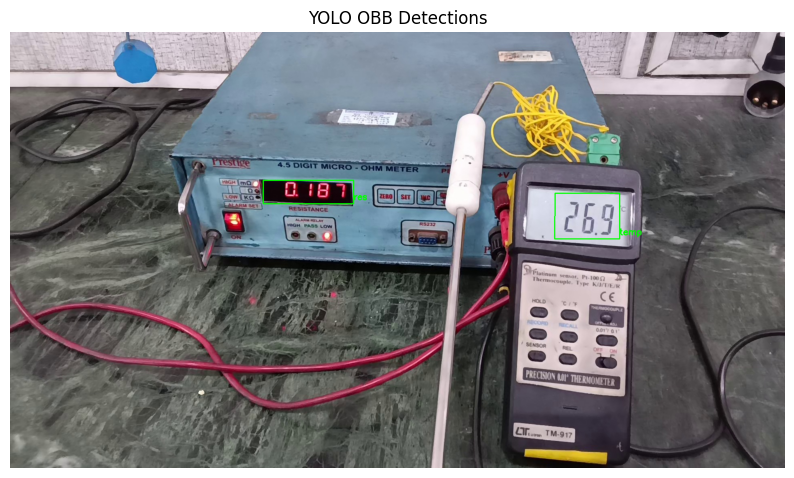

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# --- CONFIG ---
model_path = "Models/res_temp_box_v2.pt"   # your YOLO OBB model
image_path = "cr_test/61.jpg"                   # your image

# --- LOAD MODEL & IMAGE ---
model = YOLO(model_path)
img_bgr = cv2.imread(image_path)
if img_bgr is None:
    raise FileNotFoundError(f"Cannot read {image_path}")

# --- INFERENCE ---
results = model(img_bgr)

# --- DRAW OBBs ---
img_draw = img_bgr.copy()
for r in results:
    if r.obb is not None:
        obb_boxes = r.obb.xyxyxyxy.cpu().numpy()
        class_ids = r.obb.cls.cpu().numpy().astype(int)
        names = r.names
        for box, cls_id in zip(obb_boxes, class_ids):
            pts = box.reshape(4, 2).astype(np.int32)
            cv2.polylines(img_draw, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
            label = names[cls_id]
            cv2.putText(img_draw, label, (pts[0][0], pts[0][1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# --- SHOW WITH MATPLOTLIB ---
img_rgb = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("YOLO OBB Detections")
plt.show()